In [3]:
!pip install pennylane

## I. PREPROCESAMIENTO DE LOS DATOS DE ENTRADA

In [4]:
# Importación de librerías necesarias para la computación cuántica, análisis de datos y métricas de evaluación
import zipfile # Necesaria para la extracción del archivo .zip que contiene las carpetas con los conjuntos de datos
import pandas as pd # Útil para representación de métricas

# Descomprimir el dataset Titanic
with zipfile.ZipFile("titanic.zip", 'r') as zip_ref:
    zip_ref.extractall("titanic_data")


# Cargar y preparar los datos
# Convertimos las variables categóricas a variables "dummy"
# Rellenamos valores faltantes en la edad
# Creamos una nueva característica: si es niño o no. Con base en "age"

df = pd.read_csv("titanic_data/train.csv")
df['Pclass'] = df['Pclass'].astype(str)
df = pd.concat([df, pd.get_dummies(df[['Pclass', 'Sex', 'Embarked']])], axis=1)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['is_child'] = df['Age'].map(lambda x: 1 if x < 12 else 0)

# Definimos las características (features) que vamos a usar
cols = ['is_child', 'Pclass_1', 'Pclass_2', 'Sex_female']
# convertimos X en una matriz de enteros y cofificamos las etiquetas Y en un conjunto {-1, +1},
# ya que este formato es más adecuado para el clasificador cuántico con función de activación basada en signo.
X = df[cols].astype(int).values
Y = (df['Survived'] * 2 - 1).values  # {0,1} -> {-1,1}

## II. DIVISIÓN DE LOS DATOS DE ENTRENAMIENTO Y DATOS DE PRUEBA

In [5]:
from sklearn.model_selection import train_test_split
from pennylane import numpy as np
# Convertimos los datos a tensores de PennyLane compatibles con autograd
# El parámetro requires_grad=False indica que estas variables no serán entrenadas
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = np.array(X_train, requires_grad=False, dtype=int)
X_test = np.array(X_test, requires_grad=False, dtype=int)
Y_train = np.array(Y_train, requires_grad=False)
Y_test = np.array(Y_test, requires_grad=False)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


## III. ETAPA DEL FEATURE MAP

In [6]:
# Para la codificación de entrada clásica a cuántica (Feature Map)
def stateprep(x):
    qml.BasisEmbedding(x, wires=range(4))  # num_qubits = 4

## IV. ETAPA DEL ANSATZ

In [7]:
# Definimos una capa del ansatz
import pennylane as qml

# Definimos el número de qubits y capas del circuito
num_qubits = 4
num_layers = 4
# Inicializamos el dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

# Para la cconstrucción del circuito cuántico completo con Feature Map + Ansatz


# QNode principal usado durante el entrenamiento y evaluación. Recibe como entrada tanto los pesos como la muestra x.
@qml.qnode(dev, interface="autograd")
def qnode_cost(param_pack):
    weights, x = param_pack
    stateprep(x)
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return qml.expval(qml.PauliZ(0)) # Medimos vaor esperado en Z del primer qubit

# Segundo QNode utilizado exclusivamente para calcular el tensor métrico (QNG). No depende directamente de x (solo usa una muestra fija del batch).
@qml.qnode(dev, interface="autograd")
def qnode_only_weights(weights):
    stateprep(global_x_batch[0]) # Prepara el estado cuántico
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits)) # Aplica el ansatz StronglyEntanglingLayers con los pesos dados
    return qml.expval(qml.PauliZ(0)) # Retorna el valor esperado del observable Z en el primer qubit


# Clasificador cuántico variacional: suma del circuito y un bias
def classifier(weights, bias, x): # a diferencia del caso con AdamOptimizer, este deberá retornar un qnode, no un circuito. Esto es MUY importante .
    return qnode_cost((weights, x)) + bias

## V. ETAPA DE FUNCIÓN DE PERDIDA

In [8]:
3# La pérdida utilizada es: L = (y - pred)^2
# Se implementa de forma manual más adelante en la parte de entrenamiento

## VI. ETAPA DE EVALUACIÓN DE LA FUNCIÓN DE COSTO

In [9]:
from pennylane.optimize import QNGOptimizer

qng_opt = QNGOptimizer(stepsize=0.1) # Inicializamos el optimizador de gradiente natural cuántico (QNG)
bias_lr = 0.01 # Tasa de aprendizaje para el parámetro clásico de bias

## VII. ETAPA DE ANÁLISIS DE PRECISIÓN

In [10]:
from sklearn.metrics import accuracy_score

# Para la evalaiación de la exactitud
def evaluate_accuracy(X, Y, weights, bias):
    preds = [np.sign(classifier(weights, bias, x)) for x in X]
    return accuracy_score(Y, preds)

## VIII. PESOS INICIALES DEFINIDOS

In [11]:
# Determinamos la forma del tensor de pesos para el ansatz StronglyEntanglingLayers,
# en función del número de capas y qubits
shape = qml.StronglyEntanglingLayers.shape(num_layers, num_qubits)

#Inicializamos los pesos con valores aleatorios pequeños y habilitamos el cálculo de gradientes
weights = 0.1 * np.random.randn(*shape)
weights.requires_grad = True

# Inicializamos el bias clásico con cero y también habilitamos su gradiente
bias = np.tensor(0.0, requires_grad=True)

## IX. PESOS FINALES ENTRENADOS

In [12]:
print("== INICIO DEL ENTRENAMIENTO ==")
batch_size = 16
num_epochs = 100
log_interval = 5 # Frecuencia con la que se mostrarán los datos de precición y bias


# Listas para guardar el historial de accuracy y bias a lo largo del entrenamiento
acc_hist = []
bias_hist = []

# Entrenamiento del modelo usando batches aleatorios
for it in range(num_epochs):
    idx = np.random.choice(len(X_train), batch_size, replace=False)
    global_x_batch = X_train[idx]
    y_batch = Y_train[idx]

    # Paso 1: actualizar pesos
    metric_tensor = qml.adjoint_metric_tensor(qnode_only_weights)
    weights = qng_opt.step(qnode_only_weights, weights, metric_tensor_fn=metric_tensor)
    weights.requires_grad = True

    # Paso 2: actualizar bias
    preds = np.array([classifier(weights, bias, xi) for xi in global_x_batch])
    grads = -2 * (y_batch - preds)
    avg_grad = np.mean(grads)
    bias = bias - bias_lr * avg_grad

    if it % log_interval == 0 or it == num_epochs - 1: # para lo loggear todo, sino en bloques de a 5 iteraciones
        acc = evaluate_accuracy(X_train, Y_train, weights, bias)
        acc_hist.append(acc)
        bias_hist.append(bias.item())
        print(f"Iter {it:3d} | Accuracy: {acc:.3f} | Bias: {bias:.3f}")

== INICIO DEL ENTRENAMIENTO ==
Iter   0 | Accuracy: 0.520 | Bias: 0.002
Iter   5 | Accuracy: 0.508 | Bias: -0.043
Iter  10 | Accuracy: 0.517 | Bias: -0.063
Iter  15 | Accuracy: 0.618 | Bias: -0.088
Iter  20 | Accuracy: 0.605 | Bias: -0.087
Iter  25 | Accuracy: 0.624 | Bias: -0.102
Iter  30 | Accuracy: 0.338 | Bias: -0.104
Iter  35 | Accuracy: 0.688 | Bias: -0.129
Iter  40 | Accuracy: 0.683 | Bias: -0.115
Iter  45 | Accuracy: 0.584 | Bias: -0.079
Iter  50 | Accuracy: 0.584 | Bias: -0.036
Iter  55 | Accuracy: 0.633 | Bias: -0.000
Iter  60 | Accuracy: 0.633 | Bias: 0.062
Iter  65 | Accuracy: 0.633 | Bias: 0.107
Iter  70 | Accuracy: 0.633 | Bias: 0.157
Iter  75 | Accuracy: 0.633 | Bias: 0.201
Iter  80 | Accuracy: 0.633 | Bias: 0.244
Iter  85 | Accuracy: 0.633 | Bias: 0.278
Iter  90 | Accuracy: 0.633 | Bias: 0.314
Iter  95 | Accuracy: 0.633 | Bias: 0.329
Iter  99 | Accuracy: 0.633 | Bias: 0.333


## X. EVALUACIÓN DE DESEMPEÑO DEL CLASIFICADOR CUÁNTICO FINAL

In [13]:
# Métricas de evaluación
print("\n== EVALUACIÓN FINAL ==")
acc_test = evaluate_accuracy(X_test, Y_test, weights, bias)
print(f"Test accuracy: {acc_test:.3f}")


== EVALUACIÓN FINAL ==
Test accuracy: 0.603


# Comparativa de eficiencia: (AdamOptimizer, BasicEntanglerLayers) vs (QNGOptimizer, StronglyEntanglingLayers)



| Modelo | Optimizador     | Ansatz                     | Accuracy final (train) | Accuracy test
| ------ | --------------- | -------------------------- | ---------------------- | -------------
| **A**  | `AdamOptimizer` | `BasicEntanglerLayers`     | 0.78                   | 0.789         |
| **B**  | `QNGOptimizer`  | `StronglyEntanglingLayers` | 0.63                   | 0.603         |     


Modelo A (Adam + BasicEntanglerLayers) logró un mejor ajuste y generalización, alcanzando un F1-score de 0.77 en test y una accuracy superior al 78%. El entrenamiento mostró una curva de mejora constante y estable.

Modelo B (QNG + StronglyEntanglingLayers) mostró un rendimiento más inestable: comenzó cerca del azar (0.52) y osciló en accuracy entre 0.58 y 0.68 durante el entrenamiento. A pesar de usar el optimizador natural QNG (más sofisticado teóricamente), no logró superar a Adam en esta configuración.

Podría tratarse de que el StronglyEntanglingLayers introduce muchos más parámetros y entrelazamientos, con relación a los pocos datos disponibles o entrenamiento limitado, puede sobreajustar o ser más difícil de optimizar. Adicionalmente, el bias evolucionó lentamente y no compensó bien las predicciones, afectando la separación entre clases.

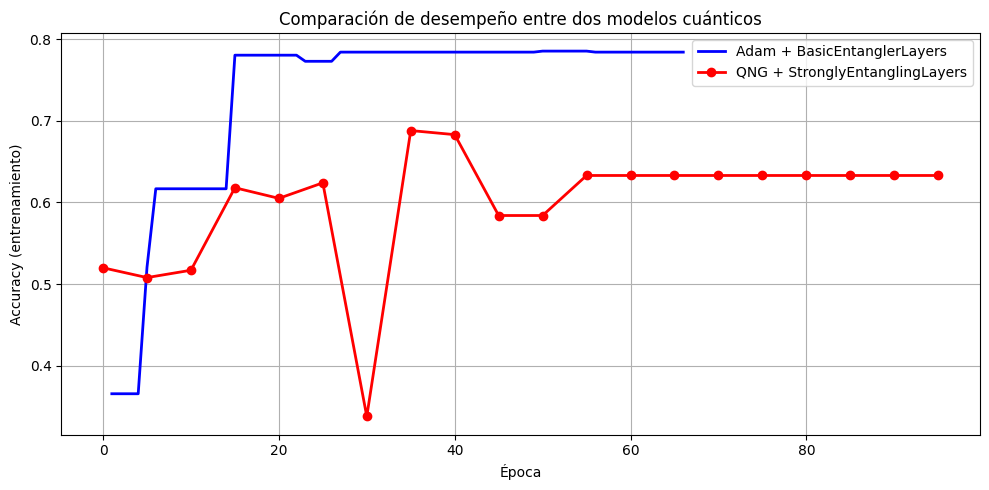

In [16]:
import matplotlib.pyplot as plt
import numpy as np

adam_epochs = np.arange(1, 67)

# Reescritura de los datos obtenidos en el Punto 1, como arreglo
adam_accuracy = [
    0.3657928, 0.3657928, 0.3657928, 0.3657928, 0.5205993, 0.6167291, 0.6167291,
    0.6167291, 0.6167291, 0.6167291, 0.6167291, 0.6167291, 0.6167291, 0.6167291,
    0.7802747, 0.7802747, 0.7802747, 0.7802747, 0.7802747, 0.7802747, 0.7802747,
    0.7802747, 0.7727840, 0.7727840, 0.7727840, 0.7727840, 0.7840200, 0.7840200,
    0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200,
    0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200,
    0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200,
    0.7852684, 0.7852684, 0.7852684, 0.7852684, 0.7852684, 0.7852684, 0.7840200,
    0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200, 0.7840200,
    0.7840200, 0.7840200, 0.7840200
]


# Reescritura de los datos obtenidos en el Punto 2, como arreglo
qng_epochs = np.arange(0, 100, 5)
qng_accuracy = [
    0.520, 0.508, 0.517, 0.618, 0.605, 0.624, 0.338,
    0.688, 0.683, 0.584, 0.584, 0.633, 0.633, 0.633,
    0.633, 0.633, 0.633, 0.633, 0.633, 0.633
]

# Gráfica comparativa
plt.figure(figsize=(10, 5))
plt.plot(adam_epochs, adam_accuracy, label="Adam + BasicEntanglerLayers", color="blue", linewidth=2)
plt.plot(qng_epochs, qng_accuracy, label="QNG + StronglyEntanglingLayers", color="red", linewidth=2, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (entrenamiento)")
plt.title("Comparación de desempeño entre dos modelos cuánticos")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
